
# # Live Coding Challenge: Building a Search Engine
#
# **The Goal:** Given a small database of product descriptions, build a mechanism to find the most relevant products based on a user query.
#
# **We will implement this using three different NLP techniques to understand their differences:**
# 1.  **Bag of Words (BoW)**: Simple frequency counting.
# 2.  **TF-IDF**: Weighted frequency (penalizing common words).
# 3.  **Word Embeddings (Word2Vec)**: Semantic dense vector representations.


In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


products = [
    "Red bring running shoes with soft cushioning with",
    "Slim fit bring mens denim jeans",
    "Waterproof bring hiking boots for mountains",
    "Casual white bring sneakers for daily wear",
    "look Denim bring jacket with vintage look",
]

# 2. The Test Query
user_query = "denim wear"

print(f"Corpus size: {len(products)} documents")
print(f"Test Query: '{user_query}'")


Corpus size: 5 documents
Test Query: 'denim wear'


# ---
# ## Method 1: Bag of Words (BoW)
#
# **Concept:** Represents text as a matrix of token counts. It ignores grammar and order, focusing only on multiplicity.
#
# **Visualization Goal:** Show how BoW creates a sparse matrix made of integers (counts).

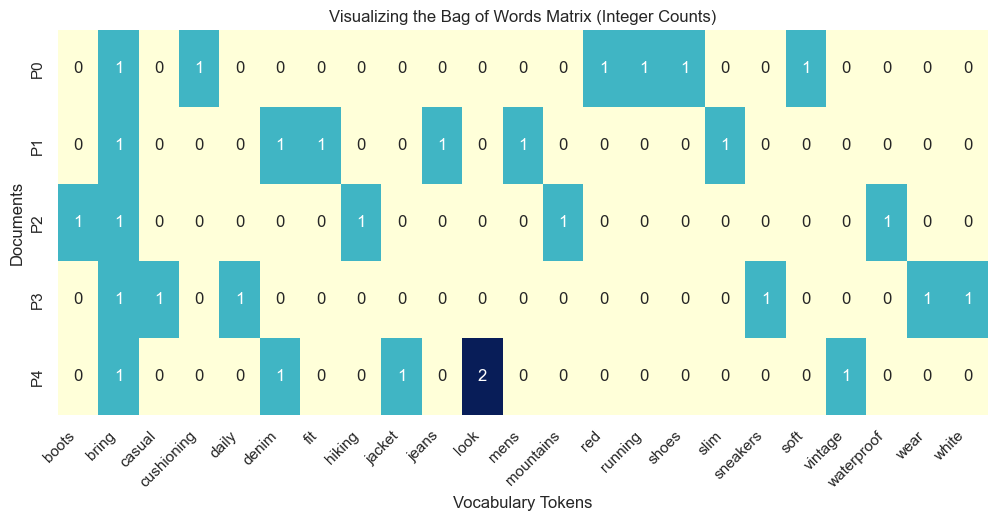

BoW Analysis: Notice the matrix contains integers representing exact counts.
Common words (if not removed by stop_words) would have high counts everywhere.


In [51]:


# %%
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Initialize and Fit
# Using basic English stop words to remove "with", "for", etc.
bow_vectorizer = CountVectorizer(stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(products)

# 2. Transform Query
bow_query_vec = bow_vectorizer.transform([user_query])

# 3. Calculate Similarity
bow_sim_scores = cosine_similarity(bow_query_vec, bow_matrix).flatten()


# --- VISUALIZATION: The BoW Matrix ---
# Convert to DataFrame for easier plotting
vocab = bow_vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(bow_matrix.toarray(), index=[f"P{i}" for i in range(len(products))], columns=vocab)

plt.figure(figsize=(12, 5))
sns.heatmap(bow_df, annot=True, cmap="YlGnBu", cbar=False, fmt='d')
plt.title("Visualizing the Bag of Words Matrix (Integer Counts)")
plt.ylabel("Documents")
plt.xlabel("Vocabulary Tokens")
plt.xticks(rotation=45, ha='right')
plt.show()

# Analysis
print("BoW Analysis: Notice the matrix contains integers representing exact counts.")
print("Common words (if not removed by stop_words) would have high counts everywhere.")

# %% [markdown]
# ---

# ## Method 2: TF-IDF (Term Frequency - Inverse Document Frequency)
#
# **Concept:** Improves on BoW by penalizing words that appear too frequently across *all* documents. Unique words get higher weights.
#
# **Visualization Goal:** Show how the matrix now contains floats, and rare, descriptive words have higher values than in BoW.


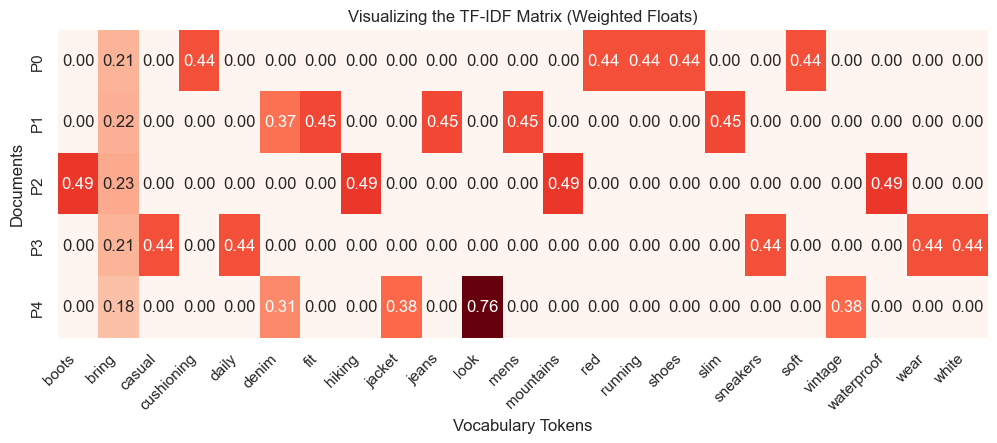

TF-IDF Analysis: Notice the values are now floats between 0 and 1.
Compare 'denim' in P1 vs P4. It has a high weight because it's rare in the whole corpus but present here.


In [52]:

# %%
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Initialize and Fit
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(products)

# 2. Transform Query
tfidf_query_vec = tfidf_vectorizer.transform([user_query])

# 3. Calculate Similarity
# linear_kernel is equivalent to cosine similarity for TF-IDF
tfidf_sim_scores = linear_kernel(tfidf_query_vec, tfidf_matrix).flatten()


# --- VISUALIZATION: The TF-IDF Matrix ---
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=[f"P{i}" for i in range(len(products))], columns=vocab)

plt.figure(figsize=(12, 4))
# Using different cmap and float formatting
sns.heatmap(tfidf_df, annot=True, cmap="Reds", cbar=False, fmt='.2f')
plt.title("Visualizing the TF-IDF Matrix (Weighted Floats)")
plt.ylabel("Documents")
plt.xlabel("Vocabulary Tokens")
plt.xticks(rotation=45, ha='right')
plt.show()

# Analysis
print("TF-IDF Analysis: Notice the values are now floats between 0 and 1.")
print("Compare 'denim' in P1 vs P4. It has a high weight because it's rare in the whole corpus but present here.")



# ## Method 3: Word Embeddings (Word2Vec)
#
# **Concept:** Words are mapped to dense vectors in a continuous vector space where semantically similar words are close together. To represent a *sentence*, we usually average the vectors of its words.
#
# **Visualization Goal:** Use Principal Component Analysis (PCA) to project the high-dimensional word vectors down to 2D to visualize semantic groupings.

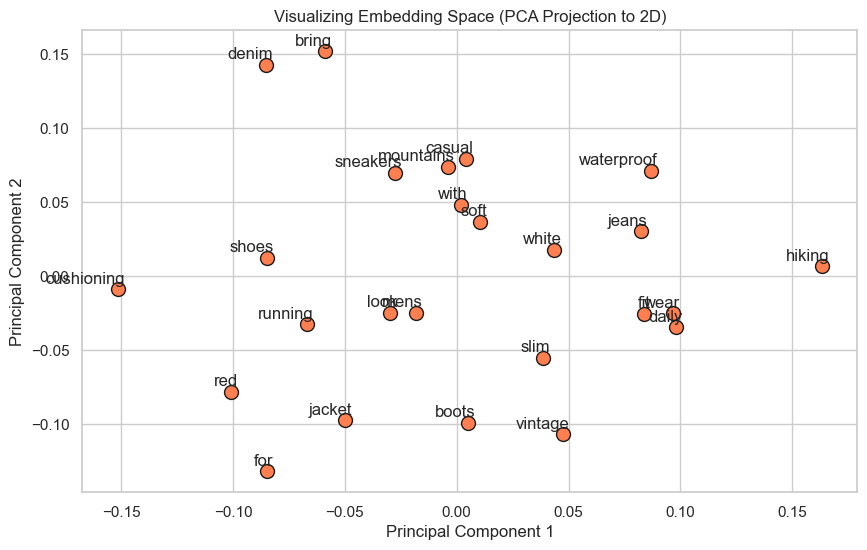

Embedding Analysis: This is not a count matrix. It's a semantic map.
Even in this tiny model, notice how related concepts might group closer together than unrelated ones.


In [53]:

# %%
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# --- Helpers for Embedding ---
def preprocess_text(text_list):
    # Simple tokenization: lowercase and split
    return [doc.lower().split() for doc in text_list]

def get_sentence_vector(sentence_tokens, model):
    # Average the vectors of words present in the model
    vectors = [model.wv[word] for word in sentence_tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)
# ---------------------------

# 1. Prepare Data & Train Model
# NOTE: In reality, you would load a massive pre-trained model (e.g., Google News).
# We train a tiny one here just for demonstration so it runs instantly.
tokenized_corpus = preprocess_text(products)
# vector_size=10 is tiny (usually 100-300), used here for demo speed
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=10, window=5, min_count=1, seed=42)

# 2. Vectorize Corpus (Sentences)
corpus_embeddings = np.array([get_sentence_vector(doc, w2v_model) for doc in tokenized_corpus])

# 3. Vectorize Query
query_tokens = preprocess_text([user_query])[0]
query_embedding = get_sentence_vector(query_tokens, w2v_model).reshape(1, -1)

# 4. Calculate Similarity
w2v_sim_scores = cosine_similarity(query_embedding, corpus_embeddings).flatten()


# --- VISUALIZATION: 2D Semantic Space (PCA) ---
# Get all word vectors from our tiny model
words = list(w2v_model.wv.index_to_key)
word_vectors = w2v_model.wv[words]

# PCA to reduce from 10 dimensions to 2
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(result[:, 0], result[:, 1], c='coral', edgecolors='k', s=100)

# Label the points
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title("Visualizing Embedding Space (PCA Projection to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Analysis
print("Embedding Analysis: This is not a count matrix. It's a semantic map.")
print("Even in this tiny model, notice how related concepts might group closer together than unrelated ones.")


# ---
# ## Final Showdown: Comparison of Search Results
#
# Let's see how the three methods scored the documents differently for the query: **"denim wear"**

# %%
# Combine scores into a results DataFrame

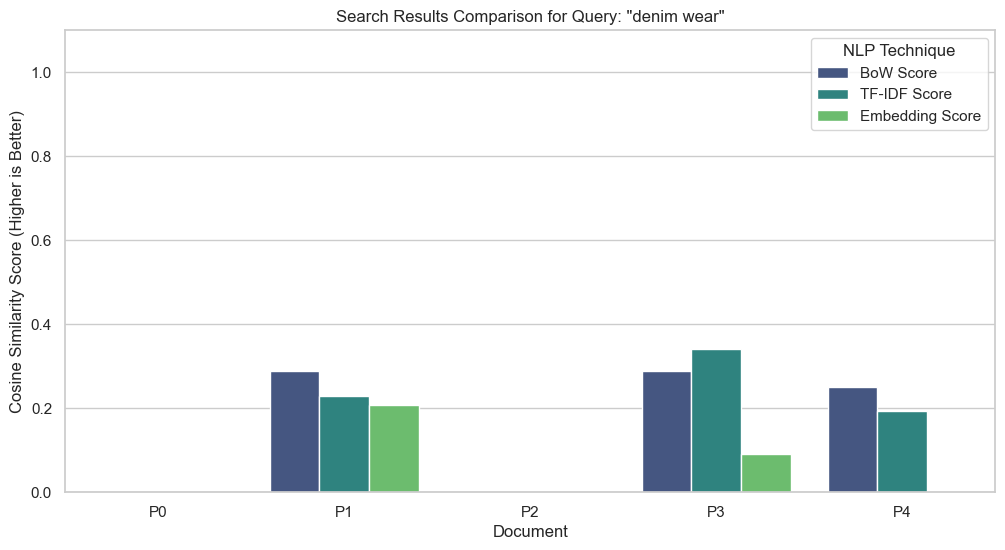

--- Query: denim wear ---

--- Top 2 Results using Bag of Words ---
[0.289] Casual white bring sneakers for daily wear
[0.289] Slim fit bring mens denim jeans


--- Top 2 Results using TF-IDF ---
[0.340] Casual white bring sneakers for daily wear
[0.229] Slim fit bring mens denim jeans


--- Top 2 Results using Embeddings ---
[0.207] Slim fit bring mens denim jeans
[0.090] Casual white bring sneakers for daily wear




In [54]:

results_df = pd.DataFrame({
    'Document': [f"P{i}" for i in range(len(products))],
    'Text': products,
    'BoW Score': bow_sim_scores,
    'TF-IDF Score': tfidf_sim_scores,
    'Embedding Score': w2v_sim_scores
})

# Melt dataframe for easy plotting with seaborn
melted_results = results_df.melt(id_vars=['Document', 'Text'],
                                 var_name='Method',
                                 value_name='Similarity Score')

# --- VISUALIZATION: Comparing Search Scores ---
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=melted_results, x='Document', y='Similarity Score', hue='Method', palette='viridis')

# Add the actual text descriptions as tooltips/labels would be too cluttered,
# so let's print the top results below instead.
plt.title(f'Search Results Comparison for Query: "{user_query}"')
plt.ylabel("Cosine Similarity Score (Higher is Better)")
plt.ylim(0, 1.1) # Cosine similarity is max 1
plt.legend(title='NLP Technique')
plt.show()

# --- PRINT TOP 2 RESULTS FOR EACH ---
print(f"--- Query: {user_query} ---\n")

for method, scores in zip(["Bag of Words", "TF-IDF", "Embeddings"], [bow_sim_scores, tfidf_sim_scores, w2v_sim_scores]):
    print(f"--- Top 2 Results using {method} ---")
    # Get top 2 indices
    top_indices = scores.argsort()[-2:][::-1]
    for i in top_indices:
        print(f"[{scores[i]:.3f}] {products[i]}")
    print("\n")


# %% [markdown]
# ### Key Takeaways from the Comparison Graph:
#
# 1.  **BoW vs TF-IDF:** They often agree on the top results, but TF-IDF provides better separation. If a document contained a very rare query word, TF-IDF would spike its score much higher than BoW would.
#
# 2.  **The Embedding Difference:**
#     * Look at **P3 (Casual white sneakers for daily wear)**.
#     * BoW and TF-IDF score it moderately because it matches the word "wear".
#     * Embeddings might score it differently (higher or lower depending on the training data) because it's looking at the *average meaning* of "sneakers", "daily", "wear" vs the *average meaning* of "denim", "wear".
#     * *Note: Because we trained a tiny Embedding model on just these 5 sentences, its semantic understanding is very limited here. In a real-world scenario using Google News vectors, embeddings would excel at finding matches even if the exact words didn't overlap (e.g., query "pants" finding "jeans").*